# Exercise 4.7: Value iteration implementation

#### <a href="http://incompleteideas.net/book/code/jacks.lisp">Original code by Sutton & Barto written in LISP</a>

### Jack’s Car Rental
<p align="justify">
Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited \$10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of \$2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number $n$ is
    $$\cfrac{\lambda^{n}}{n!}e^{-\lambda}$$
where $\lambda$ is the expected number. Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be $\gamma = 0.9$ and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.
</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import warnings

from mpl_toolkits import mplot3d
from scipy import stats
from time import time

%matplotlib inline
warnings.filterwarnings('ignore')

### Functions

In [2]:
def plot_policy(iteration):
    plt.figure(figsize=(16, 9))
    
    sns.heatmap(np.flip(policy, axis=0), annot=True, cbar=None, cmap='bwr', 
                linecolor='white', linewidths=0.05, square=True,
                yticklabels=np.arange(max_cars[0] - 1, -1, -1),
                vmin=min(actions), vmax=max(actions))
    
    plt.title(f'Policy {iteration}')
    plt.ylabel('Cars at location 1')
    plt.xlabel('Cars at location 2')
    
    plt.show()
    return

In [3]:
def plot_values_2d():
    plt.figure(figsize=(16, 9))
    
    sns.heatmap(np.flip(values, axis=0), cmap='viridis',
                linecolor='white', linewidths=0.05, square=True,
                yticklabels=np.arange(max_cars[0] - 1, -1, -1))
    
    plt.title(f'Values of the optimal policy')
    plt.ylabel('Cars at location 1')
    plt.xlabel('Cars at location 2')
    
    plt.show()
    return

In [4]:
def plot_values_3d():
    fig = plt.figure(figsize=(16, 9))
    ax = plt.axes(projection='3d')
    
    len_x, len_y = values.shape
    
    xline = np.arange(len_x)
    yline = np.arange(len_y)
    x, y = np.meshgrid(xline, yline)
    
    ax.plot_surface(x, y, values, cmap='viridis', edgecolor='none')
#     ax.view_init(elev=45, azim=-45)
    
    ax.set_title('Values of the optimal policy')
    
    ax.set_xlabel('Cars at location 1')
    ax.set_ylabel('Cars at location 2')
    ax.set_zlabel('State value')
    
    ax.set_xticks(np.arange(len_x))
    ax.set_yticks(np.arange(len_y))
    
    fig.show()
    return

### Settings

In [5]:
price_rent  = 10  # price of renting a car (profit)
cost_move   =  2  # cost of moving a car from one location to another

n_locations = 2  # number of locations

lambdas_rent = [3, 4]  # expected number of cars to rent per location
lambdas_back = [3, 2]  # expected number of cars to return per location
max_cars     = [20 + 1, 20 + 1]  # maximum number of cars per location
max_caps     = [10, 10]  # maximum capacity per location

gamma = 0.90   # discount rate
min_p = 1e-6   # minimum probability
theta = 1e-9   # accuracy of estimation

In [6]:
# actions: number of cars to move from location 1 to location 2
# - negative numbers denote movement from location 2 to location 1
actions = list(range(-5, 5+1))
print(actions)

max_move = max(map(abs, actions))

[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]


### Initialization

In [7]:
policy = None
values = None
P      = None
R      = None

In [8]:
def initialization():
    global policy, values, P, R
    
    policy = np.zeros(max_cars, dtype=np.int)  # policy
    values = np.zeros(max_cars)  # state space

    P = dict()  # probabilities that the number of cars is (day, night)
    P[0] = np.zeros([max_cars[0] + max_move, max_cars[0]])
    P[1] = np.zeros([max_cars[1] + max_move, max_cars[1]])

    R = dict()  # expected rewards due to satisfied requests (day, night)
    R[0] = np.zeros(max_cars[0] + max_move)
    R[1] = np.zeros(max_cars[1] + max_move)

    # load probablity and reward tables
    for i in range(n_locations):
        requests = 0
        
        while True:
            request_prob = stats.poisson.pmf(requests, lambdas_rent[i])
            
            if request_prob < min_p:
                break

            for n in range(max_cars[i] + max_move):
                R[i][n] += price_rent * request_prob * min(requests, n)

            dropoffs = 0
            
            while True:
                drop_prob = stats.poisson.pmf(dropoffs, lambdas_back[i])
                
                if drop_prob < min_p:
                    break

                for n in range(max_cars[i] + max_move):
                    satisfied_requests = min(requests, n)
                    new_n = max(0, min(20, (n + dropoffs - satisfied_requests)))
                    P[i][n, new_n] += request_prob * drop_prob

                dropoffs += 1

            requests += 1
            
    return

### Value iteration

In [9]:
def backup_action(n1, n2, a, cost_park=0, free_rides=0):
    a = max(-n2, min(a, n1))
    a = max(actions[0], min(actions[-1], a))
    
    morning_n1 = n1 - a
    morning_n2 = n2 + a
    
    value = - abs(a) * cost_move
    
    if morning_n1 > max_caps[0]:
        value -= cost_park
    if morning_n2 > max_caps[1]:
        value -= cost_park
    
    if a > 0:  # if there is a need to move a car from n1 to n2
        value += cost_move * min(a, free_rides)  # give back the money for the car shuttled by the employee
    
    for new_n1 in range(max_cars[0]):
        for new_n2 in range(max_cars[1]):
            value += (
                P[0][morning_n1, new_n1] * 
                P[1][morning_n2, new_n2] * 
                (R[0][morning_n1] + R[1][morning_n2] + 
                 gamma * values[new_n1, new_n2]))
            
    return value

In [10]:
def value_iter(cost_park=0, free_rides=0, epsilon=1e-9):
    delta = theta
    stable = True
    
    while delta >= theta:
        delta = 0
        
        for n1 in range(max_cars[0]):
            for n2 in range(max_cars[1]):
                best_v = -np.inf
                best_a = policy[n1, n2]
                
                for action in range(max(actions[0], -n2),
                                    min(actions[-1], n1) + 1):
                    this_value = backup_action(n1, n2, action,
                                               cost_park, free_rides)

                    if best_v + epsilon < this_value:
                        best_v = this_value
                        best_a = action
                        
                if policy[n1, n2] != best_a:
                    policy[n1, n2] = best_a
                    stable = False
                    
                delta = max(delta, abs(best_v - values[n1, n2]))
                values[n1, n2] = best_v
                
    return stable

In [11]:
def run(cost_park=0, free_rides=0):
    initialization()

    iteration = 0
    stable = False

    plot_policy(iteration)

    while not stable:
        iteration += 1

        stable = value_iter(cost_park, free_rides)

        if not stable:
            plot_policy(iteration)

    plot_values_2d()
    plot_values_3d()

<hr style="height: 1px;">

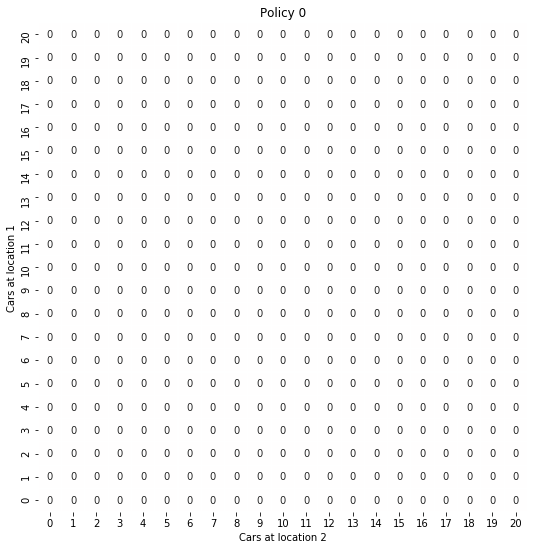

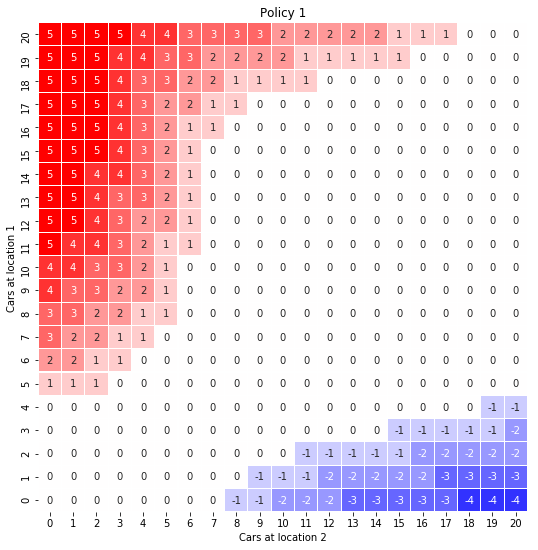

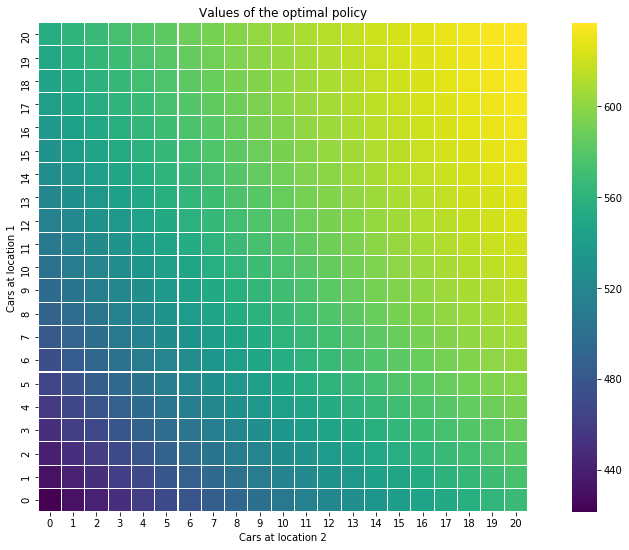

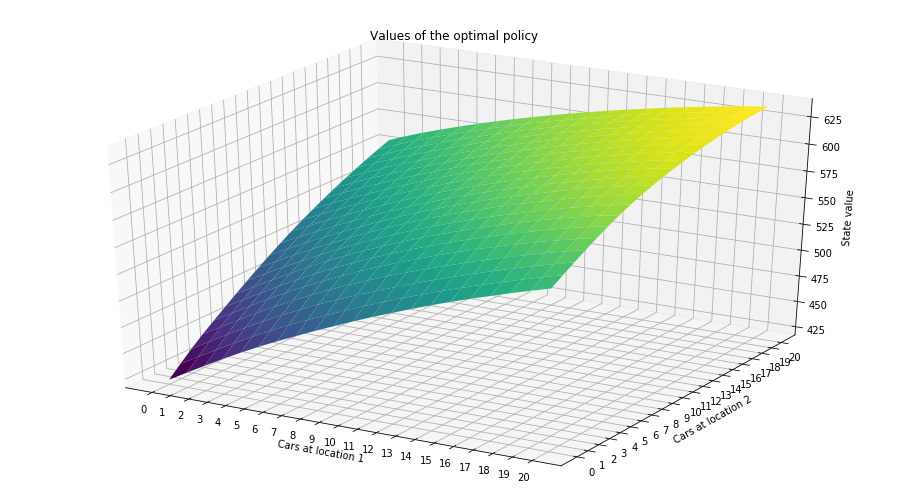

In [12]:
run(cost_park=0, free_rides=0)

<hr style="height: 1px;">

<p align="justify">
Write a program for policy iteration and re-solve Jack’s car rental problem with the following changes. One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs \$2, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of \$4 must be incurred to use a second parking lot (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often
occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your program, first replicate the results given for the original problem.
</p>

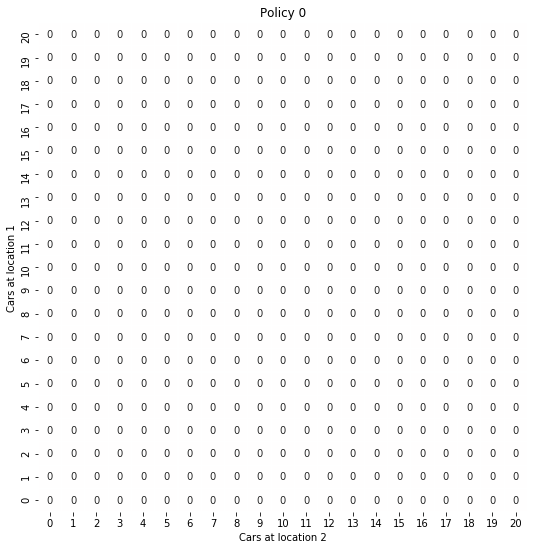

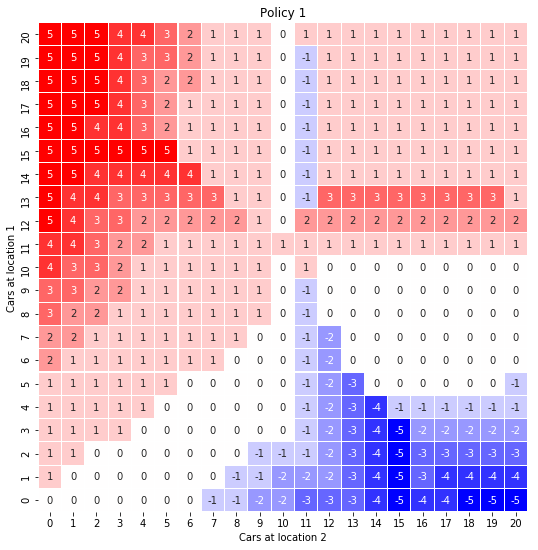

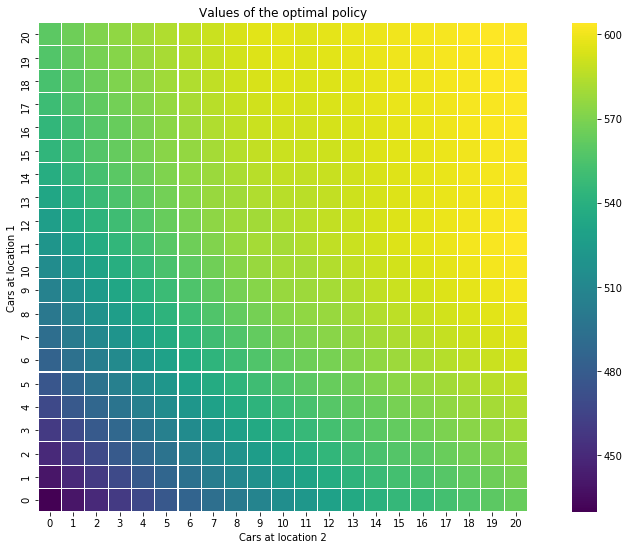

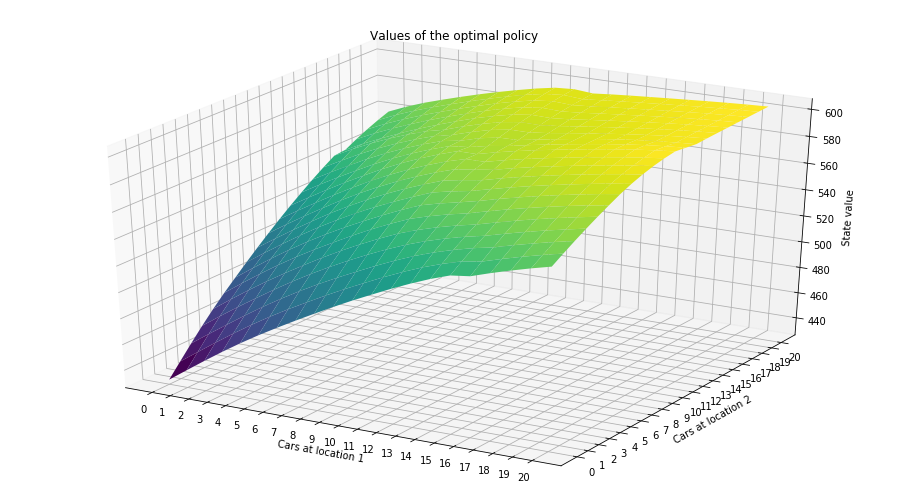

In [13]:
run(cost_park=4, free_rides=1)